# parallel_bootstrap example

Load example output from parallel_bootstrap.  Five models were fitted to real-estate data obtained using the code in the streeteasy_scrape repository.  The output here was generated using code in bashBoot directory, but identical results can be obtained using code from the sparkBoot directory.  The details of the models are explained in the streeteasy_model repository.  Here, we will plot 95% confidence intervals on the model fit statistics (RMSE and R<sup>2</sup>) to evaluate the statistical significance of differences across models.   

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from parallel_bootstrap import txt2df, predict, rmse_dist, r2_dist

Get the distribution of RMSE and R<sup>2</sup> for each model.

In [72]:
model_list = ['reduced','scraped','amen','trans','inter']
coef = {}; info = {}; feats = {}; target = {}; pred = {}; rmse = {}; r2 = {}
for m in model_list:
    #display
    print "Now analyzing %s..." % (m),
    #format coefficients in dataframe
    coef[m], info[m] = txt2df('example_output/bashBoot_output_%s_train.txt' % (m))
    #load data
    feats_temp = pd.read_csv('bashBoot/data/%s_feats.csv' % (m)).drop('Unnamed: 0',axis=1)
    target_temp = pd.read_csv('bashBoot/data/%s_target.csv' % (m)).drop('Unnamed: 0',axis=1)
    #reduce to only test set
    feats[m]  = feats_temp[feats_temp['test_set'] == 1]
    target[m] = target_temp[feats_temp['test_set'] == 1]
    #drop column
    feats[m] = feats[m].drop('test_set',axis=1)    
    #generate predictions
    pred[m] = predict(coef[m],feats[m])
    #compute rmse distribution over bootstraps
    rmse[m] = rmse_dist(target[m]['price'],pred[m])
    #compute r2 distribution over bootstraps
    r2[m] = r2_dist(target[m]['price'],pred[m])
    #print
    print "Finished."

Now analyzing reduced... Finished.
Now analyzing scraped... Finished.
Now analyzing amen... Finished.
Now analyzing trans... Finished.
Now analyzing inter... Finished.


Compute the standard error and 95% confidence intervals (2-tailed) for RMSE and R<sup>2</sup>.

In [53]:
rmse_stats = {'mean': np.array([]), 'se': np.array([]), 'LB': np.array([]), 'UB': np.array([])}
r2_stats = {'mean': np.array([]), 'se': np.array([]), 'LB': np.array([]), 'UB': np.array([])}
for m in model_list:
    rmse_stats['mean'] =  np.append(rmse_stats['mean'],np.mean(rmse[m]))
    rmse_stats['se'] =  np.append(rmse_stats['se'],np.std(rmse[m]))
    rmse_stats['LB'] =  np.append(rmse_stats['LB'],np.percentile(rmse[m],2.5))
    rmse_stats['UB'] =  np.append(rmse_stats['UB'],np.percentile(rmse[m],97.5))
    r2_stats['mean'] =  np.append(r2_stats['mean'],np.mean(r2[m]))
    r2_stats['se'] =  np.append(r2_stats['se'],np.std(r2[m]))
    r2_stats['LB'] =  np.append(r2_stats['LB'],np.percentile(r2[m],2.5))
    r2_stats['UB'] =  np.append(r2_stats['UB'],np.percentile(r2[m],97.5))
    

### Summarize in tables

RMSE

In [54]:
rmse_df = pd.DataFrame(rmse_stats)
rmse_df.rename(columns = {'LB': '95% CI (lower bound)', 'UB':'95% CI (upper bound)','mean':'Mean','se':'Standard error'}, inplace = True)
rmse_df.rename(index = {0: 'reduced', 1:'scraped',2:'amen',3:'trans',4:'inter'})

,95% CI (lower bound),95% CI (upper bound),Mean,Standard error
reduced,1267.360383,1273.886184,1270.647768,1.794453
scraped,959.515808,964.675980,962.079568,1.316796
amen,876.808132,881.855295,879.441172,1.438867
trans,874.117474,879.719122,876.972675,1.539755
inter,747.381252,855.210794,768.629552,29.178826


R<sup>2</sup>

In [56]:
r2_df = pd.DataFrame(r2_stats)
r2_df.rename(columns = {'LB': '95% CI (lower bound)', 'UB':'95% CI (upper bound)','mean':'Mean','se':'Standard error'}, inplace = True)
r2_df.rename(index = {0: 'reduced', 1:'scraped',2:'amen',3:'trans',4:'inter'})

,95% CI (lower bound),95% CI (upper bound),Mean,Standard error
reduced,0.483199,0.488480,0.485822,0.001452
scraped,0.703636,0.706798,0.705229,0.000807
amen,0.752339,0.755166,0.753693,0.000806
trans,0.753538,0.756666,0.755073,0.000860
inter,0.767013,0.822112,0.811582,0.015657


### Plot with error bars.

Plot RMSE for each model with standard error bars.

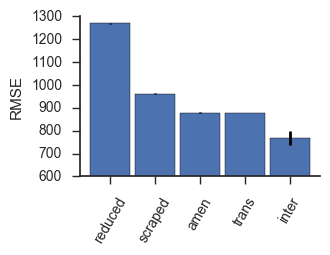

In [67]:
#RMSE bar plot with SE
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,rmse_stats['mean'],yerr = rmse_stats['se'],width = w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([600,1300])
ax.set_xlim([min(ind)-(w/4),max(ind)+w+(w/4)])
ax.set_xticks(ind+(w/2))
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('RMSE')

Plot RMSE for each model with 95% CI error bars.

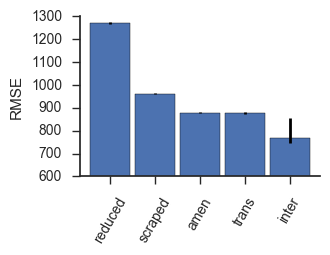

In [68]:
#RMSE bar plot with 95% CIs
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,rmse_stats['mean'],width=w,yerr = [rmse_stats['mean']-rmse_stats['LB'],rmse_stats['UB']-rmse_stats['mean']],
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([600,1300])
ax.set_xlim([min(ind)-(w/4),max(ind)+w+(w/4)])
ax.set_xticks(ind+(w/2))
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('RMSE')

Plot R<sup>2</sup> for each model with standard error bars.

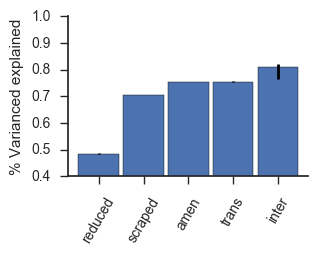

In [69]:
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,r2_stats['mean'],yerr = [r2_stats['mean']-r2_stats['LB'],r2_stats['UB']-r2_stats['mean']],width=w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([0.4,1])
ax.set_xlim([min(ind)-(w/4),max(ind)+w+(w/4)])
ax.set_xticks(ind+(w/2))
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('% Varianced explained')

Plot R<sup>2</sup> for each model with 95% CI error bars.

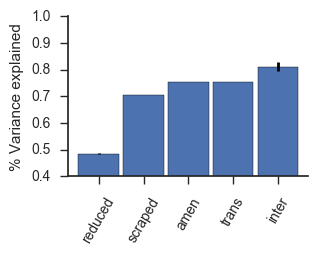

In [70]:
#RMSE bar plot with SE
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,r2_stats['mean'],yerr = r2_stats['se'],width = w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([.4,1])
ax.set_xlim([min(ind)-(w/4),max(ind)+w+(w/4)])
ax.set_xticks(ind+(w/2))
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('% Variance explained')